In [12]:
# import necessary libraries

import os
import subprocess

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from PIL import Image
import cv2

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.nn.functional import cosine_similarity

In [11]:
# check if dataset exists, if not download and extract it
if not os.path.exists('rgbd_dataset_freiburg1_xyz'):
    # download dataset
    subprocess.run(['wget', 'https://vision.in.tum.de/rgbd/dataset/freiburg1/rgbd_dataset_freiburg1_xyz.tgz'])
    # extract dataset
    subprocess.run(['tar', '-xzf', 'rgbd_dataset_freiburg1_xyz.tgz'])

In [18]:
# define custom PyTorch dataset for TUM RGB-D dataset
class TUMRGBDDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        # load file containign RGB images and timestamps
        self.rgb_txt = pd.read_csv(os.path.join(root_dir, 'rgb.txt'),
                                   skiprows=3, sep=' ', names=['timestamp', 'file'])
        # define transform for the images
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # convert images to PyTorch tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize image data for use with resnet pretrained on imagenet
        ])
    
    def __len__(self):
        # length of dataset is number of lines in RGB images file
        return len(self.rgb_txt)
    
    def __getitem__(self, idx):
        # get path of the image
        img_path = os.path.join(self.root_dir, self.rgb_txt.iloc[idx]['file'])
        # load image
        image = Image.open(img_path).convert('RGB')
        # apply transforms to the images
        image = self.transform(image)
        return image

In [19]:
# load pretrain models
model = models.resnet50(pretrained=True)
model = model.eval()

/Users/drkp4/.pyenv/versions/mambaforge/envs/mEnv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/drkp4/.pyenv/versions/mambaforge/envs/mEnv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# remove the last layer to extract features
model = torch.nn.Sequential(*(list(model.children())[:-1]))

In [21]:
# initialize dataset
dataset = TUMRGBDDataset('rgbd_dataset_freiburg1_xyz')

In [23]:
# load and preprocess first two RGB images
image1 = dataset[0].unsqueeze(0)  # add a batch dimension
image2 = dataset[1].unsqueeze(0)  # add a batch dimension

In [24]:
# extract features from image using the ResNet model
with torch.no_grad():  # no need to calculate gradients
    features1 = model(image1).squeeze()  # remove batch dimension
    features2 = model(image2).squeeze()  # remove batch dimension

In [28]:
# flatten the feature tensors
features1 = features1.view(features1.size(0), -1)
features2 = features2.view(features1.size(0), -1)

In [35]:
# compute cosine similarity between feature vectors
similarity = cosine_similarity(features1, features2, dim=1)
similarity

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [34]:
# mean of similarities
mean_similarity = torch.mean(similarity)
mean_similarity

tensor(1.)

TypeError: Invalid shape (1, 3, 480, 640) for image data

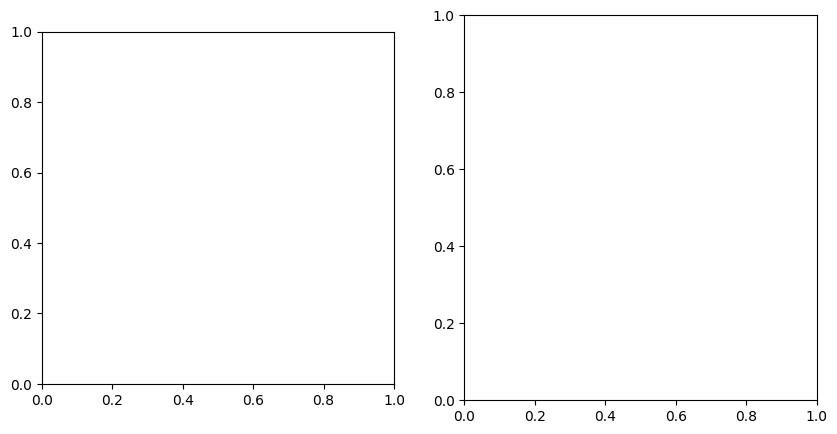

In [36]:
# Display the images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image1)
axs[0].set_title('Image 1')
axs[1].imshow(image2)
axs[1].set_title('Image 2')
plt.show()